In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")


In [11]:

df_train = pd.read_csv("/content/customer_churn_dataset-training-master.csv")



In [6]:
print(df.head())

   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  
3              29.0    1.0  
4              20.0    1.

In [12]:

df = df_train[df_train["Churn"] == 1].copy()

print(df.head())
print("Train (churn=1) shape:", df.shape)
print(df.info())
print(df.describe().T)

print("Missing counts:\n", df.isnull().sum())
print("Missing %:\n", (df.isnull().mean()*100).round(2))
print("Duplicate rows:", df.duplicated().sum())


   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  
3              29.0    1.0  
4              20.0    1.

In [13]:

target = "Tenure"

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target]

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != "customerID" and c != "CustomerID"]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['CustomerID', 'Age', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']
Categorical columns: ['Gender', 'Subscription Type', 'Contract Length']


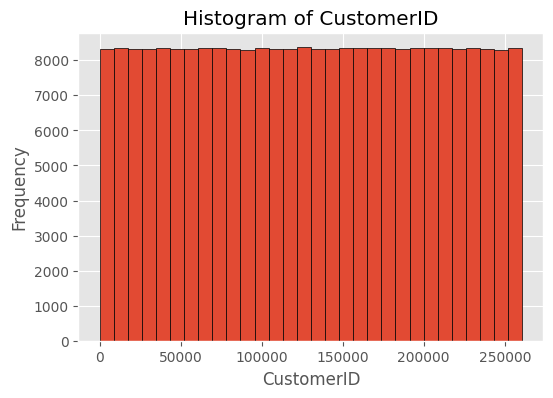

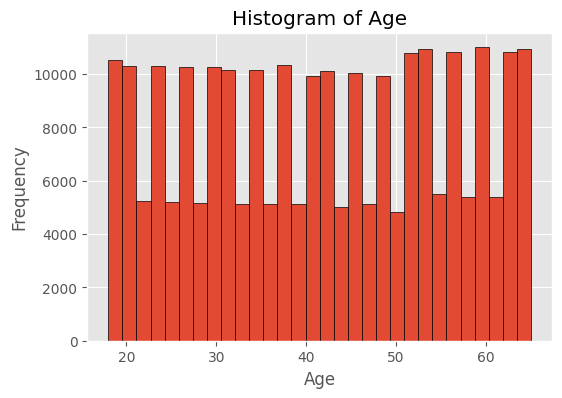

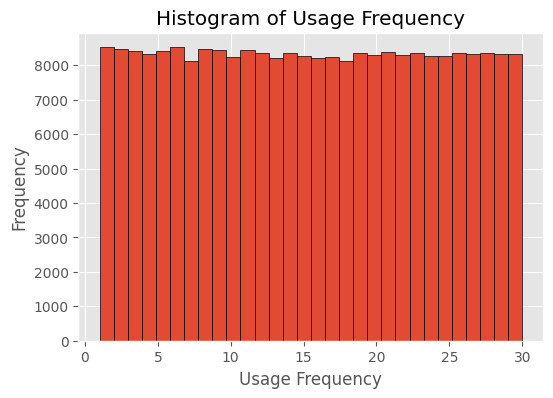

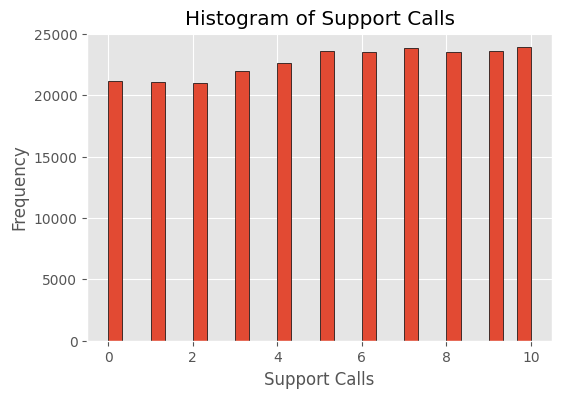

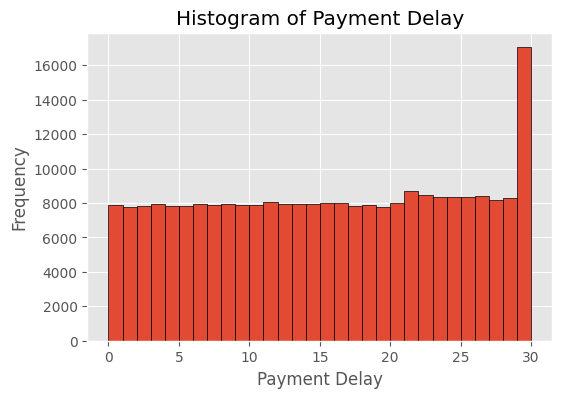

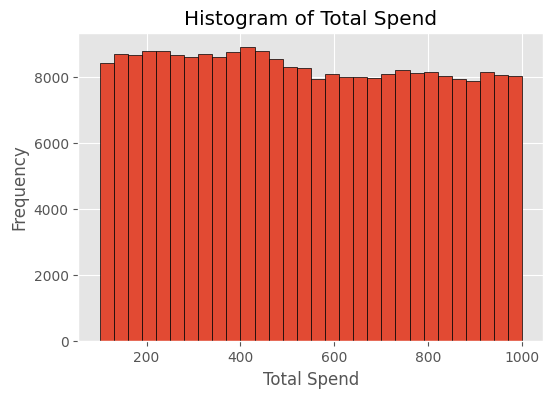

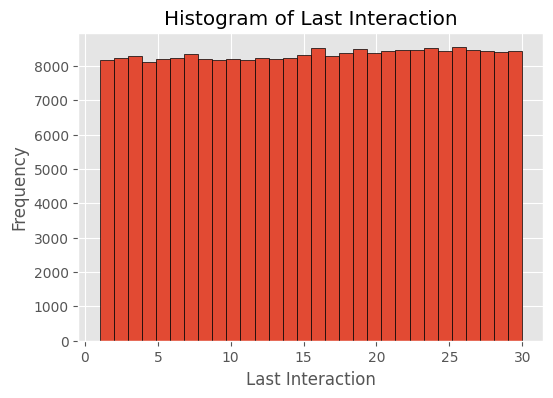

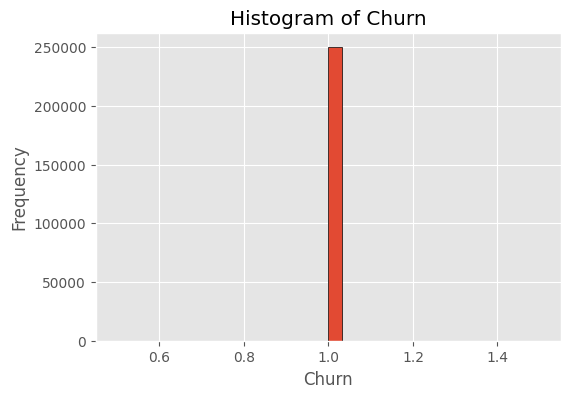

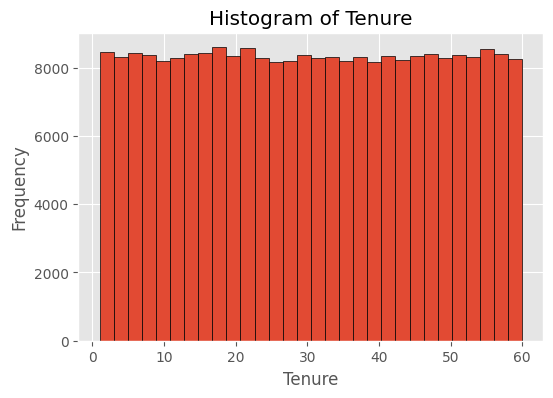

In [14]:
for col in numeric_cols + [target]:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=30, edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


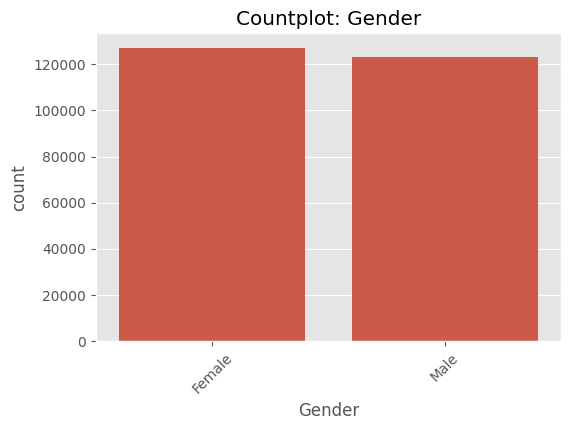

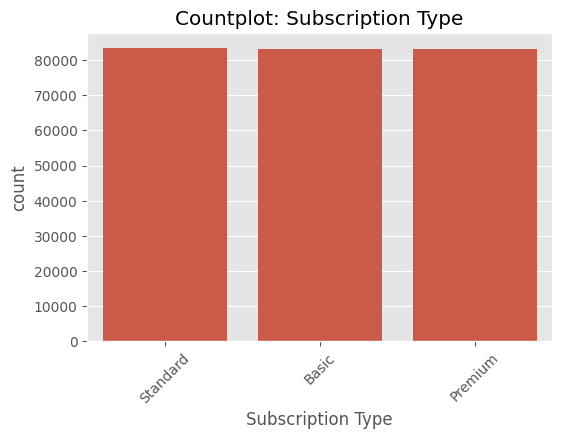

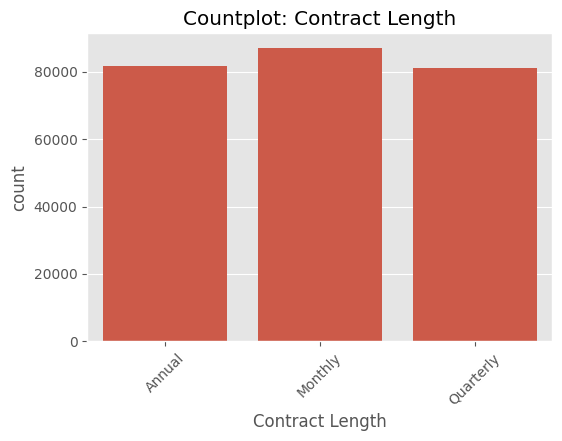

In [15]:
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col])
    plt.title(f"Countplot: {col}")
    plt.xticks(rotation=45)
    plt.show()


In [17]:

iqr_bounds = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    iqr_bounds[col] = (lower, upper)
    df[col] = df[col].clip(lower, upper)
    print(f"Capped {col}: lower={lower:.3f}, upper={upper:.3f}")



Capped CustomerID: lower=-130335.500, upper=391176.500
Capped Age: lower=-6.000, upper=90.000
Capped Usage Frequency: lower=-14.500, upper=45.500
Capped Support Calls: lower=-7.000, upper=17.000
Capped Payment Delay: lower=-17.000, upper=47.000
Capped Total Spend: lower=-360.500, upper=1443.500
Capped Last Interaction: lower=-14.500, upper=45.500
Capped Churn: lower=1.000, upper=1.000


In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
print("Encoding complete. Example mapping for first column:")
first_cat = categorical_cols[0] if categorical_cols else None
if first_cat:
    print(first_cat, dict(enumerate(label_encoders[first_cat].classes_)))


Encoding complete. Example mapping for first column:
Gender {0: 'Female', 1: 'Male'}


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print("Scaling complete. Scaled numeric columns head:")
display(df[numeric_cols].head())


Scaling complete. Scaled numeric columns head:


,CustomerID,Age,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
0,-1.732329,-0.840588,-0.168486,-0.046110,0.310035,1.503614,0.161233,0.0
1,-1.732316,1.663874,-1.667005,1.545419,-0.804288,0.060475,-1.109722,0.0
2,-1.732302,0.948314,-1.321193,0.272196,0.310035,-1.371119,-1.456346,0.0
3,-1.732289,1.162982,0.638408,0.590502,-0.915720,-0.559113,1.547728,0.0
4,-1.732276,-1.341480,0.523138,-0.046110,-0.804288,0.291377,0.507856,0.0


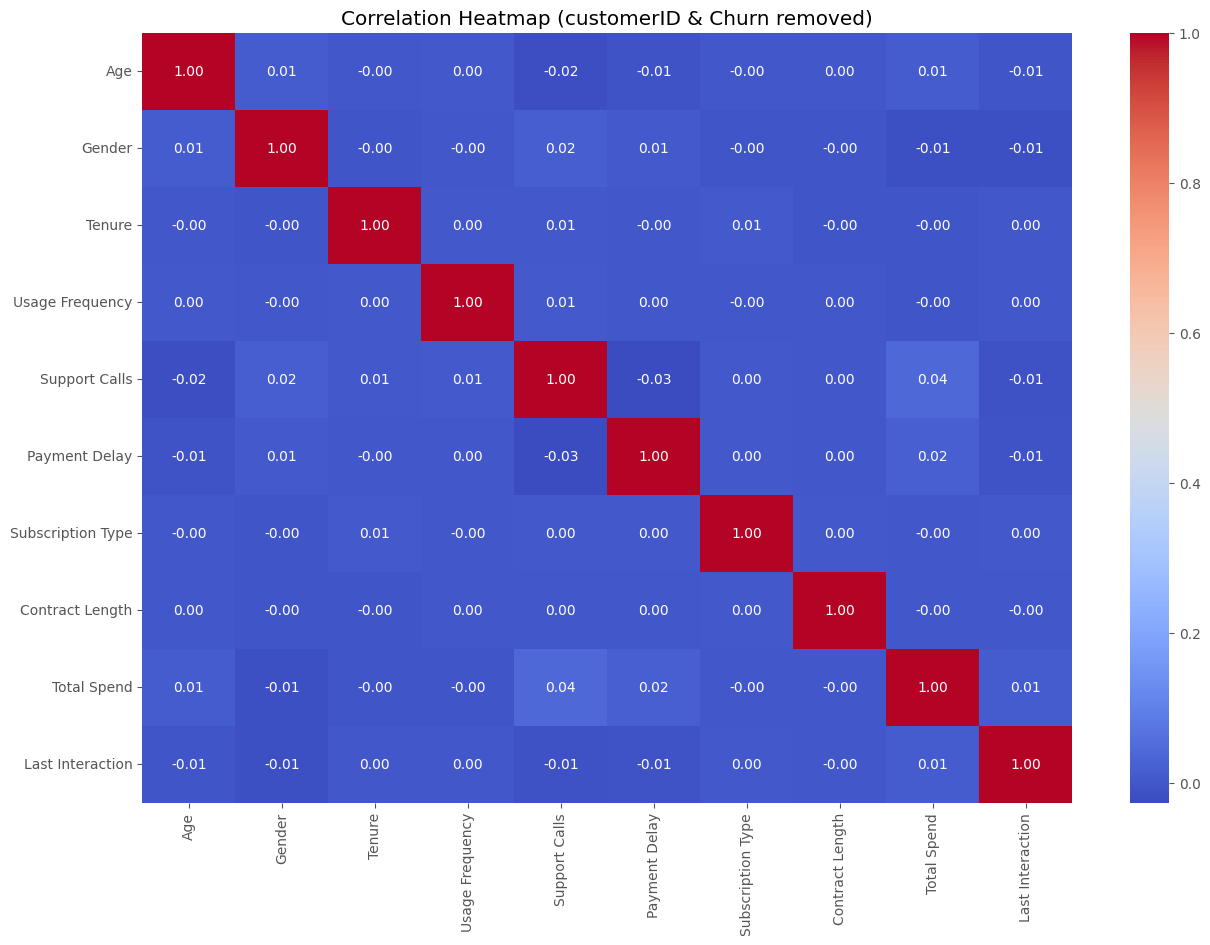

In [20]:
# drop ID columns if they exist in dataset and Churn too for heatmap clarity
drop_cols = [c for c in ["CustomerID", "customerID", "Churn"] if c in df.columns]
df_heatmap = df.drop(columns=drop_cols, errors='ignore')

plt.figure(figsize=(15,10))
sns.heatmap(df_heatmap.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap (customerID & Churn removed)")
plt.show()
